## Variables à ajouter issues des recherches biblio

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 

In [349]:
# !pip install ydata_profiling
!pip install tabulate


In [349] used -33.9 MiB RAM in 4.97s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1431.0 MiB


In [350]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)
from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

imu.start_watching_memory()



In [350] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 60%), peaked 0.0 MiB above final usage, current RAM usage now 1431.0 MiB


# TODO -- Introduction  (Business Understanding) 

## TODO Détermination objectifs métier , analytique du projet 

## TODO Identifier les contraintes , limites et risque du projet

# 2. Data understanding (compréhension des données)


## 2.1.  Chargement des données

### Chargement des différentes bases de données + étude du chargement en mémoire

In [351]:
df = pd.read_csv("data/athlete_events.csv")
region_df = pd.read_csv("data/noc_regions.csv")
dictionary = pd.read_csv("data/dictionary.csv")

In [351] used 39.1 MiB RAM in 0.46s (system mean cpu 3%, single max cpu 83%), peaked 12.7 MiB above final usage, current RAM usage now 1470.2 MiB


In [352]:
# méthode pour calculer la taille réelle occupée par le dataframe : les index occupent aussi de la place en mémoire
df.memory_usage(index=True).sum()

31695012

In [352] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1470.2 MiB


32534052 octets = 32,53 MB =  32534,052 KB.

## 2.2 Décrire les données

### Charger les données avec describe_csv et indiquer les types optimaux pour chaque colonne. 

In [353]:
describe_csv("data/athlete_events.csv", delimiter=',')

0 M rows approx.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
---------------------------------------------------
data/athlete_events.csv
---------------------------------------------------
       Col     type   min    max  nulls optimal type
0     Name   object     -      -      -       object
1      Sex   object     -      -      -       object
2      Age  float64  10.0   97.0   9633         int8
3   Height  float64  0.01  226.0  67360      float16
4   Weight  float64  25.0  214.0  74749        int16
5     Team   object     -      -      -       object
6      NOC   object     -      -      -       object
7    Games   object     -      -      -       object
8     Year    int64  1896   2020      0        int16
9   Season   object     -      -      -       object
10    City   object     -      -      -       object
11   Sport   object     -      -      -       object
12   Event   object     -      -      -       object
13   Medal   object     -      -  

In [354]:
describe_csv("data/noc_regions.csv", delimiter=',')
describe_csv("data/dictionary.csv", delimiter=',')

0 M rows approx.
1 
---------------------------------------------------
data/noc_regions.csv
---------------------------------------------------
      Col    type min max nulls optimal type
0     NOC  object   -   -     -       object
1  region  object   -   -     -       object
2   notes  object   -   -     -       object

 0  rows
0 M rows approx.
1 
---------------------------------------------------
data/dictionary.csv
---------------------------------------------------
              Col     type         min            max nulls optimal type
0         Country   object           -              -     -       object
1            Code   object           -              -     -       object
2      Population  float64     10222.0   1371220000.0     5        int32
3  GDP per Capita  float64  277.068309  101449.968168    25      float32

 201  rows
In [354] used 0.0 MiB RAM in 0.12s (system mean cpu 2%, single max cpu 75%), peaked 0.0 MiB above final usage, current RAM usage now 1474.9 MiB


In [355]:
print(df.isnull().sum())

Name           0
Sex          159
Age         9633
Height     67360
Weight     74749
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport        159
Event       9492
Medal     240825
dtype: int64
In [355] used 0.1 MiB RAM in 0.15s (system mean cpu 4%, single max cpu 100%), peaked 2.7 MiB above final usage, current RAM usage now 1475.0 MiB


## EDA

### Terget Medals : Nous allons construire des représentations graphiques nous permettant d'observer les Medals en fonction des autres variables.On effectue des transformations sur les données pour les besoins de cette analyse exploratoire (pas forcément les mêmes transformations que celles nécessaires lors de l'étape de Feature engineering).

In [356]:
df.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [356] used 0.0 MiB RAM in 0.11s (system mean cpu 3%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1475.0 MiB


In [357]:
# RUSSIA
df.loc[(df['Team'] == 'Soviet Union') & (df['NOC'] == 'URS'), ['Team', 'NOC']] = ['Russia', 'RUS'] # URSS période 1952-1988
df.loc[(df['Team'] == 'ROC') & (df['NOC'] == 'ROC'), ['Team', 'Russia']] = ['Germany', 'RUS'] # JO 2020

# GERMANY
df.loc[(df['Team'] == 'East Germany') & (df['NOC'] == 'GDR'), ['Team', 'NOC']] = ['Germany', 'GER']

# CHINA
df.loc[df['Team'] == "People's Republic of China", ['Team', 'NOC']] = ['China', 'CHN']

# UNITED STATES
df.loc[df['Team'] == "United States of America", ['Team', 'NOC']] = ['United States', 'USA']



In [357] used 8.9 MiB RAM in 0.20s (system mean cpu 2%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1483.9 MiB


In [358]:
df.drop_duplicates(inplace=True)


In [358] used 32.2 MiB RAM in 0.32s (system mean cpu 3%, single max cpu 100%), peaked 15.2 MiB above final usage, current RAM usage now 1516.2 MiB


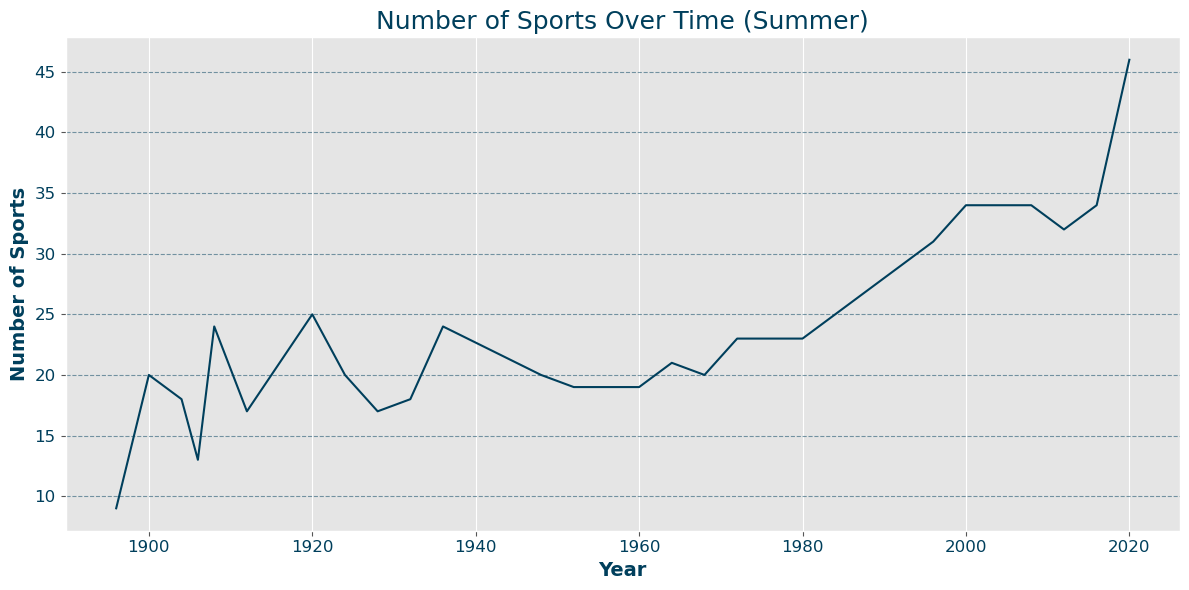

In [359] used 3.0 MiB RAM in 0.33s (system mean cpu 5%, single max cpu 100%), peaked 30.9 MiB above final usage, current RAM usage now 1519.2 MiB


In [359]:
summer_sports_per_year = df[df['Season'] == 'Summer'].groupby('Year')['Sport'].nunique()

plt.figure(figsize=(12, 6))
plt.plot(summer_sports_per_year.index, summer_sports_per_year.values, color='#003f5c')
plt.title('Number of Sports Over Time (Summer)', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Sports', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.tight_layout()
plt.show()

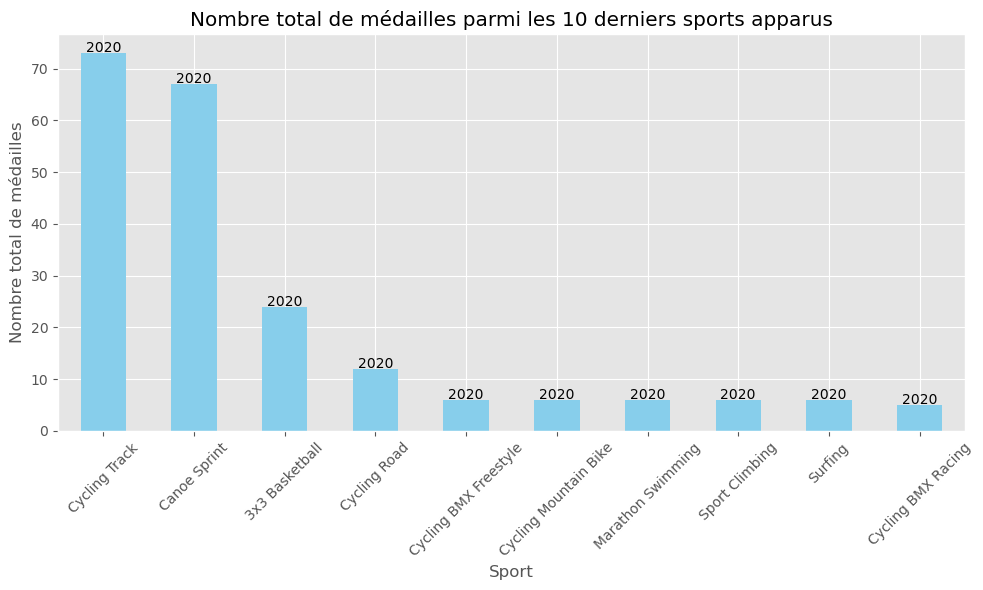

In [360] used 26.1 MiB RAM in 0.31s (system mean cpu 5%, single max cpu 100%), peaked 2.3 MiB above final usage, current RAM usage now 1545.3 MiB


In [360]:
# Filtrer les données pour inclure uniquement les Jeux olympiques d'été
summer_games = df[df['Season'] == 'Summer']

# Identifier les années où chaque sport est apparu pour la première fois
first_appearance = summer_games.groupby('Sport')['Year'].min()

# Sélectionner les 10 derniers sports apparus
latest_sports = first_appearance.sort_values(ascending=False).head(10)

# Filtrer les données pour inclure seulement les médailles des 10 derniers sports
latest_sports_medals = summer_games[summer_games['Sport'].isin(latest_sports.index)]

# Compter le nombre total de médailles par sport
medal_counts = latest_sports_medals.groupby('Sport')['Medal'].count().sort_values(ascending=False)

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
bar_plot = medal_counts.plot(kind='bar', color='skyblue')

# Ajouter l'année d'apparition à chaque barre
for i, v in enumerate(medal_counts):
    sport_name = medal_counts.index[i]
    year = first_appearance[sport_name]
    bar_plot.text(i, v + 0.2, str(year), ha='center')

plt.title('Nombre total de médailles parmi les 10 derniers sports apparus')
plt.xlabel('Sport')
plt.ylabel('Nombre total de médailles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

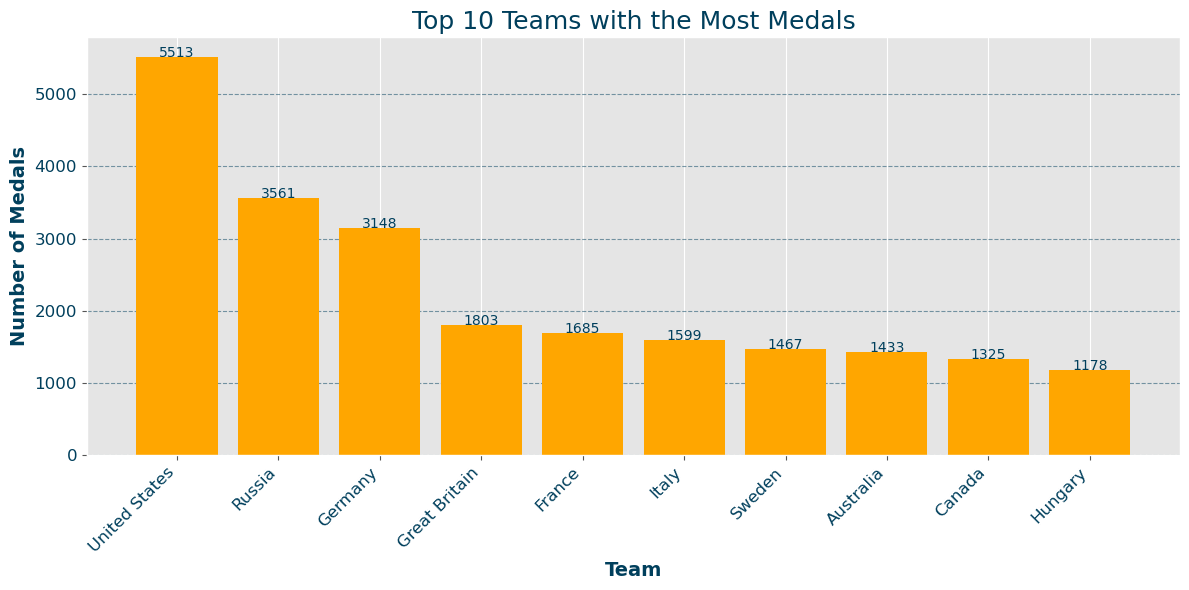

In [361] used 3.2 MiB RAM in 0.26s (system mean cpu 4%, single max cpu 100%), peaked 5.4 MiB above final usage, current RAM usage now 1548.5 MiB


In [361]:
top_10_teams = df.groupby('Team')['Medal'].count().nlargest(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_teams.index, top_10_teams.values, color='#ffa600')
plt.title('Top 10 Teams with the Most Medals', fontsize=18, color='#003f5c')
plt.xlabel('Team', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(rotation=45, ha='right', fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')

# Add the number of medals on top of each bar
for i, v in enumerate(top_10_teams.values):
    plt.text(i, v + 0.5, str(v), ha='center', color='#003f5c')

plt.tight_layout()
plt.show()




In [362]:
# Filter the data to include only the 2020 Tokyo Olympics and relevant medal types
relevant_medals = ['Gold', 'Silver', 'Bronze']
tokyo_2020 = df[(df['Year'] == 2020) & (df['Medal'].isin(relevant_medals))]

# Group the data by team and count the number of relevant medals won by each team
medal_counts = tokyo_2020.groupby('Team')['Medal'].count()

# Select the top 5 teams with the most relevant medals
top_5_teams = medal_counts.nlargest(5)

# Print the top 5 teams with their medal counts
print(top_5_teams)


Team
United States    294
Germany          223
China            140
France           135
Great Britain    130
Name: Medal, dtype: int64
In [362] used 0.0 MiB RAM in 0.12s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1548.5 MiB


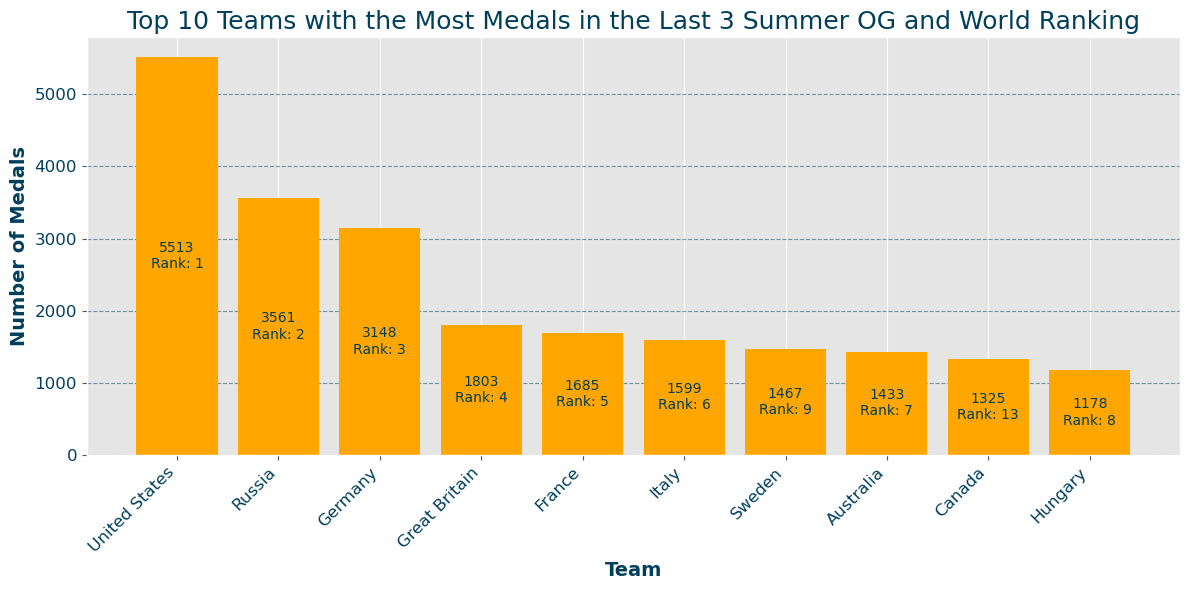

In [363] used 3.3 MiB RAM in 0.31s (system mean cpu 2%, single max cpu 100%), peaked 28.2 MiB above final usage, current RAM usage now 1551.8 MiB


In [363]:
# Calculate the total number of medals won by each team since 1900
total_medals = df[(df['Season'] == 'Summer') & (df['Year'] >= 1900)].groupby('Team')['Medal'].count()

# Sort the teams based on the total number of medals won in descending order
sorted_teams = total_medals.sort_values(ascending=False)

# Assign a rank to each team based on its position in the sorted list
ranks = {team: rank+1 for rank, team in enumerate(sorted_teams.index)}

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_10_teams.index, top_10_teams.values, color='#ffa600')
plt.title('Top 10 Teams with the Most Medals in the Last 3 Summer OG and World Ranking', fontsize=18, color='#003f5c')
plt.xlabel('Team', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(rotation=45, ha='right', fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')

# Add the number of medals and the rank inside each bar
for i, team in enumerate(top_10_teams.index):
    plt.text(i, top_10_teams.values[i]/2, f"{top_10_teams.values[i]}\nRank: {ranks[team]}", ha='center', va='center', color='#003f5c')

plt.tight_layout()
plt.show()


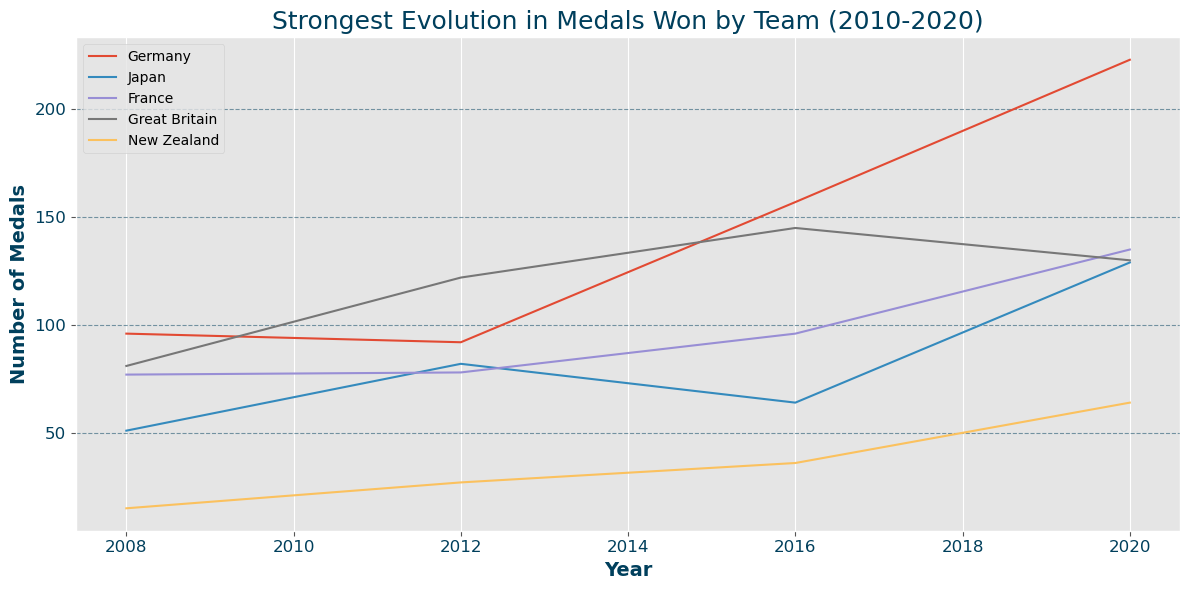

In [364] used -20.9 MiB RAM in 0.29s (system mean cpu 6%, single max cpu 100%), peaked 20.9 MiB above final usage, current RAM usage now 1531.0 MiB


In [364]:
# Filter the data to include only Summer Olympic Games between 2010 and 2020
summer_games = df[(df['Season'] == 'Summer') & (df['Year'] >= 2008) & (df['Year'] <= 2020)]

# Group the data by team and year, and calculate the total number of medals won by each team in each year
medals_by_year = summer_games.groupby(['Team', 'Year'])['Medal'].count().unstack()

# Calculate the difference in the number of medals won by each team between the first year and the last year
medal_difference = medals_by_year.iloc[:, -1] - medals_by_year.iloc[:, 0]

# Sort the teams based on the difference in the number of medals won in descending order
sorted_teams = medal_difference.sort_values(ascending=False)

# Select the top 5 teams with the largest increase in medals won
top_5_teams = sorted_teams.index[:5]

# Create a line chart showing the number of medals won by the top 5 teams in each year
plt.figure(figsize=(12, 6))
for team in top_5_teams:
    plt.plot(medals_by_year.loc[team], label=team)
plt.title('Strongest Evolution in Medals Won by Team (2010-2020)', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.legend()
plt.tight_layout()
plt.show()


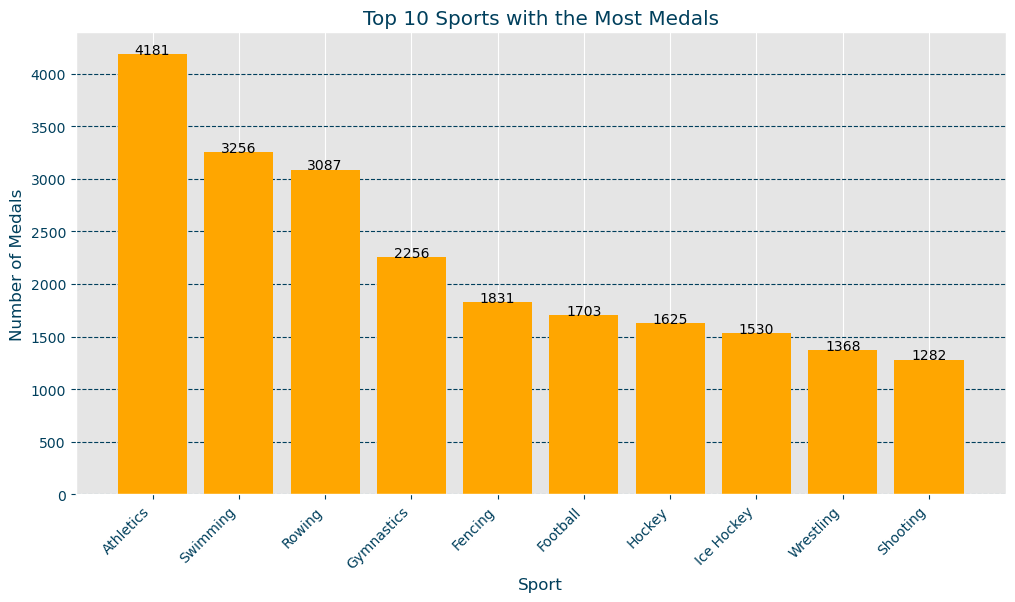

In [365] used -0.0 MiB RAM in 0.26s (system mean cpu 4%, single max cpu 100%), peaked 5.1 MiB above final usage, current RAM usage now 1531.0 MiB


In [365]:
top_10_sports = df.groupby('Sport')['Medal'].count().nlargest(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_10_sports.index, top_10_sports.values, color='#ffa600')
ax.set_title('Top 10 Sports with the Most Medals', color='#003f5c')
ax.set_xlabel('Sport', color='#003f5c')
ax.set_ylabel('Number of Medals', color='#003f5c')
ax.tick_params(axis='both', colors='#003f5c')
ax.grid(axis='y', linestyle='--', color='#003f5c')

for i, sport in enumerate(top_10_sports.index):
    ax.text(i, top_10_sports[sport] + 0.5, str(top_10_sports[sport]), color='black', ha='center')

plt.xticks(rotation=45, ha='right')
plt.show()


In [366]:

import tabulate

# Group the data by athlete name and count the number of medals
top_10_athletes = df.groupby(['Name', 'Sport'])['Medal'].count().sort_values(ascending=False).head(10)

# Reset the index to create columns for Name and Sport
top_10_athletes = top_10_athletes.reset_index()

# Rename the columns
top_10_athletes.columns = ['Athlete', 'Sport', 'Medal Count']

# Print the table using tabulate
print(tabulate.tabulate(top_10_athletes, headers='keys', tablefmt='grid', numalign='right'))


+----+------------------------------------+------------+---------------+
|    | Athlete                            | Sport      |   Medal Count |
+====+====================================+============+===============+
|  0 | Michael Fred Phelps, II            | Swimming   |            28 |
+----+------------------------------------+------------+---------------+
|  1 | Larysa Semenivna Latynina (Diriy-) | Gymnastics |            18 |
+----+------------------------------------+------------+---------------+
|  2 | Nikolay Yefimovich Andrianov       | Gymnastics |            15 |
+----+------------------------------------+------------+---------------+
|  3 | Takashi Ono                        | Gymnastics |            13 |
+----+------------------------------------+------------+---------------+
|  4 | Borys Anfiyanovych Shakhlin        | Gymnastics |            13 |
+----+------------------------------------+------------+---------------+
|  5 | Edoardo Mangiarotti                | Fencing

In [367]:
# Calculate the minimum and maximum age
min_age = df['Age'].min()
max_age = df['Age'].max()

# Group the data by age and count the number of medals for each age group
medals_by_age = df.groupby('Age')['Medal'].count()

# Filter the data between min and max age
filtered_medals_by_age = medals_by_age.loc[min_age:max_age]

# Plot the distribution of medals in relation to age
plt.figure(figsize=(12, 6))
plt.title('Distribution of Medals in Relation to Age', fontsize=18, fontweight='bold', color='#003f5c')
plt.xlabel('Age', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.bar(filtered_medals_by_age.index, filtered_medals_by_age.values, color='#5c3d7a', edgecolor='white')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.xlim(min_age - 0.5, max_age + 0.5)
plt.tight_layout()
plt.show()


## Fusion des bases + Nettoyage

In [ ]:
df = pd.read_csv("data/athlete_events.csv")
region_df = pd.read_csv("data/noc_regions.csv")
dictionary = pd.read_csv("data/dictionary.csv")

In [ ]:
df.head()

#### Normalisation de pays en-tête de classement (Russie, Allemagne)

In [ ]:
# RUSSIA
df.loc[(df['Team'] == 'Soviet Union') & (df['NOC'] == 'URS'), ['Team', 'NOC']] = ['Russia', 'RUS'] # URSS période 1952-1988
df.loc[(df['Team'] == 'ROC') & (df['NOC'] == 'ROC'), ['Team', 'Russia']] = ['Germany', 'RUS'] # JO 2020

# GERMANY
df.loc[(df['Team'] == 'East Germany') & (df['NOC'] == 'GDR'), ['Team', 'NOC']] = ['Germany', 'GER']

# CHINA
df.loc[df['Team'] == "People's Republic of China", ['Team', 'NOC']] = ['China', 'CHN']

# UNITED STATES
df.loc[df['Team'] == "United States of America", ['Team', 'NOC']] = ['United States', 'USA']


#### Nous nous interessons au JO SUMMER seulement 

In [ ]:
df = df[df['Season'] == "Summer"]
print(df.shape)

### Merge avec noc_regions.csv 


In [ ]:
df = df.merge(region_df[['NOC', 'region']], how='left', on='NOC')
print(df.shape)

### Merge avec dictionary.csv 


In [ ]:
df = df.merge(dictionary[['Code', 'GDP per Capita']], how='left', left_on='NOC', right_on='Code')
df.drop('Code', axis=1, inplace=True)
print(df.shape)

In [ ]:
df.head()

In [ ]:
df.isna().sum()

## 3.2. Nettoyer les données

### 3.2.1. Données manquantes

In [ ]:
# Vérification des valeurs NULL 
df.isnull().sum() 

#### Traitement des valeurs nulles de la colonne Embarked

Essayez de deviner le sex des athletes manquants

In [ ]:
missing_sex = df[df['Sex'].isnull()]
missing_sex